<a href="https://colab.research.google.com/github/mpirko/DivvyBikeIdealPlacement/blob/main/DivvyBikeIdealPlacementBinned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install ipython-sql
!pip install pandas
!pip install pandasql
!pip install geopy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%cd /content/drive/MyDrive/DivvyBike/

/content/drive/MyDrive/DivvyBike


In [ ]:
import pandas as pd

# List of file names
file_names = [
    '202304-divvy-tripdata.csv',
    '202303-divvy-tripdata.csv',
    '202302-divvy-tripdata.csv',
    '202301-divvy-tripdata.csv',
    '202212-divvy-tripdata.csv',
    '202211-divvy-tripdata.csv',
    '202210-divvy-tripdata.csv',
    '202209-divvy-publictripdata.csv',
    '202208-divvy-tripdata.csv',
    '202207-divvy-tripdata.csv',
    '202206-divvy-tripdata.csv',
    '202205-divvy-tripdata.csv'
]

# Specify the file path for the output CSV file
output_file_path = 'combined_divvy_rides.csv'

# Define the column names
column_names = ['ride_id', 'rideable_type', 'started_at', 'ended_at',
                'start_station_name', 'start_station_id', 'end_station_name',
                'end_station_id', 'start_lat', 'start_lng', 'end_lat',
                'end_lng', 'member_casual']

# Chunk size for processing
chunk_size = 100000

# Initialize an empty DataFrame for storing the combined data
df_combined = pd.DataFrame()

# Process each file in chunks and append to the combined DataFrame
for i, file_name in enumerate(file_names):
    file_path = file_name
    
    # Read the file in chunks
    for chunk in pd.read_csv(file_path, header=None, chunksize=chunk_size, engine='python'):
        df_combined = pd.concat([df_combined, chunk])

# Save the combined DataFrame to the output CSV file without column names
df_combined.to_csv(output_file_path, index=False, header=False)

In [4]:
import pandas as pd

# Read the CSV file with specified data types or low_memory=False
df_combined = pd.read_csv('combined_divvy_rides.csv', dtype={'column_name': str}, low_memory=False)

# Print the first row
print(df_combined.head(1))

            ride_id  rideable_type           started_at             ended_at  \
0  8FE8F7D9C10E88C7  electric_bike  2023-04-02 08:37:28  2023-04-02 08:41:37   

  start_station_name start_station_id end_station_name end_station_id  \
0                NaN              NaN              NaN            NaN   

  start_lat start_lng end_lat end_lng member_casual  
0      41.8     -87.6   41.79   -87.6        member  


In [5]:
import pandas as pd

# Read the combined CSV file
df_combined = pd.read_csv('combined_divvy_rides.csv')

# Filter rows where rides only started at a station
started_only_count = df_combined[df_combined['end_station_id'].isna() & df_combined['start_station_id'].notna()].shape[0]

# Filter rows where rides only ended at a station
ended_only_count = df_combined[df_combined['start_station_id'].isna() & df_combined['end_station_id'].notna()].shape[0]

# Filter rows where rides both started and ended at a station
started_and_ended_count = df_combined[df_combined['start_station_id'].notna() & df_combined['end_station_id'].notna()].shape[0]

# Calculate the total number of rides
total_rides = len(df_combined)

# Calculate the percentages
started_only_percentage = (started_only_count / total_rides) * 100
ended_only_percentage = (ended_only_count / total_rides) * 100
started_and_ended_percentage = (started_and_ended_count / total_rides) * 100
neither_started_nor_ended_percentage = 100 - started_only_percentage - ended_only_percentage - started_and_ended_percentage

# Print the results
print(f"Percentage of rides that only started at a station: {started_only_percentage:.2f}%")
print(f"Percentage of rides that only ended at a station: {ended_only_percentage:.2f}%")
print(f"Percentage of rides that both started and ended at a station: {started_and_ended_percentage:.2f}%")
print(f"Percentage of rides that neither started nor ended at a station: {neither_started_nor_ended_percentage:.2f}%")


<ipython-input-5-67e64d3c9857>:4: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined = pd.read_csv('combined_divvy_rides.csv')


Percentage of rides that only started at a station: 8.41%
Percentage of rides that only ended at a station: 7.43%
Percentage of rides that both started and ended at a station: 77.38%
Percentage of rides that neither started nor ended at a station: 6.77%


In [5]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Read the combined Divvy rides data
df_combined = pd.read_csv('combined_divvy_rides.csv')

# Group the data by start station coordinates and count the number of rides
station_counts = df_combined.groupby(['start_lat', 'start_lng', 'start_station_name']).size().reset_index(name='ride_count')

# Sort the stations by ride count in descending order
station_counts = station_counts.sort_values('ride_count', ascending=False)

# Take the top N stations with the highest ride count
top_n_stations = station_counts.head(100)

# Create a folium map centered around Chicago
map_divvy = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Add a heatmap layer based on the start station coordinates and ride count
heatmap_data = top_n_stations[['start_lat', 'start_lng', 'ride_count']].values.tolist()
HeatMap(heatmap_data).add_to(map_divvy)

# Add markers for the top N stations
for idx, row in top_n_stations.iterrows():
    lat, lng = row['start_lat'], row['start_lng']
    ride_count = row['ride_count']
    station_name = row['start_station_name']
    folium.Marker(
        location=[lat, lng],
        popup=f"Station: {station_name}<br>Ride Count: {ride_count}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map_divvy)

# Display the map
map_divvy


<ipython-input-5-6697f23fbf41>:6: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined = pd.read_csv('combined_divvy_rides.csv')


In [ ]:
import pandas as pd
from scipy.spatial import distance
import numpy as np
import time
from tqdm import tqdm

# Read the Divvy Bike stations data
df_stations = pd.read_csv('Divvy_Bicycle_Stations_-_All_-_Map.csv')

# Create a HashMap of station coordinates and names
station_map = dict(zip(zip(df_stations['Latitude'], df_stations['Longitude']), df_stations['Station Name']))

# Load the combined bike rides data in chunks
chunk_size = 100000
ride_chunks = pd.read_csv('combined_divvy_rides.csv', chunksize=chunk_size)

# Prepare a list to store filtered data
filtered_data = []

# Iterate over the ride chunks
for df_chunk in ride_chunks:
    # Filter rides without Divvy bike start or end station
    df_filtered = df_chunk[df_chunk['start_station_id'].isna() & df_chunk['end_station_id'].isna()]

    # Filter out rows with missing or invalid coordinates
    df_filtered = df_filtered.dropna(subset=['start_lat', 'start_lng'])

    # Convert coordinates to float
    df_filtered['start_lat'] = df_filtered['start_lat'].astype(float)
    df_filtered['start_lng'] = df_filtered['start_lng'].astype(float)

    # Calculate distances using the HashMap
    ride_start_points = df_filtered[['start_lat', 'start_lng']].values
    nearest_station_coords = list(station_map.keys())
    distances = distance.cdist(ride_start_points, nearest_station_coords, metric='cityblock')
    nearest_station_indices = distances.argmin(axis=1)
    nearest_station_names = [station_map[nearest_station_coords[i]] for i in nearest_station_indices]

    # Add the filtered data to the list
    df_filtered['nearest_station_distance'] = distances.min(axis=1)
    df_filtered['nearest_station_name'] = nearest_station_names
    filtered_data.append(df_filtered)

# Concatenate all filtered data into a single DataFrame
df_filtered = pd.concat(filtered_data)

# Select the required columns
columns_to_keep = ['nearest_station_distance', 'nearest_station_name', 'start_lat', 'start_lng', 'end_lat', 'end_lng']
df_filtered = df_filtered[columns_to_keep]

# Save the filtered data to a new file
df_filtered.to_csv('binned_nearest_divvy_location.csv', index=False)

# Preparation Stage
start = time.time()

# Define the values to bin
values = df_filtered['nearest_station_distance'].values

# Set the number of bins
bins = 100000

# Calculate bin intervals
values_min = values.min()
values_max = values.max()
values_range = values_max - values_min
interval_range = values_range / bins

bin_intervals = {b: (values_min + b * interval_range, values_min + (b + 1) * interval_range) for b in range(bins)}

# Fill up bins with indices of values
bin_idx_dict = {}
for b, interval in tqdm(bin_intervals.items()):
    low = interval[0]
    high = interval[1]
    bin_idx_dict[b] = np.where((values >= low) & (values < high))[0].flatten()

end = time.time()
print(end - start)

# Implementation
start = time.time()

# Define the value to bin mapping function
val_to_bin_idx = lambda x: int((x - values_min) / interval_range)

# Define the value for which to find the nearest neighbors
val_match = values.min()  # Minimum distance between the bike and any of the stations

neighbor_bin_idx_center = val_to_bin_idx(val_match)
neighbor_center_idx = bin_idx_dict[neighbor_bin_idx_center]
neighbor_center = values[neighbor_center_idx]

neighbor_left = None
neighbor_bin_idx_left = neighbor_bin_idx_center
while neighbor_left is None:
    neighbor_bin_idx_left -= 1
    try:
        neighbor_left_idx = bin_idx_dict[neighbor_bin_idx_left]
        if neighbor_left_idx.shape[0] > 0:
            neighbor_left = values[neighbor_left_idx]
    except KeyError:
        neighbor_left_idx = np.array([])
        neighbor_left = np.array([])

neighbor_right = None
neighbor_bin_idx_right = neighbor_bin_idx_center
while neighbor_right is None:
    neighbor_bin_idx_right += 1
    try:
        neighbor_right_idx = bin_idx_dict[neighbor_bin_idx_right]
        if neighbor_right_idx.shape[0] > 0:
            neighbor_right = values[neighbor_right_idx]
    except KeyError:
        neighbor_right_idx = np.array([])
        neighbor_right = np.array([])

neighbor_idx = np.concatenate([neighbor_left_idx, neighbor_center_idx, neighbor_right_idx]).astype(int)
neighbors = np.concatenate([neighbor_left, neighbor_center, neighbor_right])

dist1d = np.abs(neighbors - val_match)
min_dist = dist1d.min()
idx = np.where(dist1d == min_dist)[0]  
print(val_match)
print(neighbor_idx[idx], values[neighbor_idx[idx]])

end = time.time()
print(end - start)



<ipython-input-8-8b8ba2dea8be>:21: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-8-8b8ba2dea8be>:21: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-8-8b8ba2dea8be>:21: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-8-8b8ba2dea8be>:21: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-8-8b8ba2dea8be>:21: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-8-8b8ba2dea8be>:21: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_m

51.987762212753296
0.00021518799999142857
[   108    518    770 ... 396703 396706 396750] [0.00021519 0.00021519 0.00021519 ... 0.00021519 0.00021519 0.00021519]
0.006096839904785156


In [6]:
 import pandas as pd
import folium
from folium.plugins import HeatMap

# Read the filtered data with nearest Divvy bike locations
df_filtered = pd.read_csv('binned_nearest_divvy_location.csv')

# Group the data by nearest station coordinates and count the number of occurrences
station_counts = df_filtered.groupby(['start_lat', 'start_lng', 'nearest_station_name']).size().reset_index(name='count')

# Sort the stations by count in descending order
station_counts = station_counts.sort_values('count', ascending=False)

# Take the top N stations with the highest count
top_n_stations = station_counts.head(200)

# Create a folium map centered around Chicago
map_divvy = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Add a heatmap layer based on the start station coordinates and count
heatmap_data = top_n_stations[['start_lat', 'start_lng', 'count']].values.tolist()
HeatMap(heatmap_data).add_to(map_divvy)

# Add markers for the top N stations
for idx, row in top_n_stations.iterrows():
    lat, lng = row['start_lat'], row['start_lng']
    count = row['count']
    station_name = row['nearest_station_name']
    folium.Marker(
        location=[lat, lng],
        popup=f"Station: {station_name}<br>Count: {count}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map_divvy)

# Display the map
map_divvy




In [ ]:
import pandas as pd

# Read the top 100 stations from the combined_divvy_rides.csv
df_combined = pd.read_csv('combined_divvy_rides.csv')
top_combined_stations = df_combined.groupby(['start_station_name']).size().nlargest(100).index.tolist()

# Read the top 100 stations from the binned_nearest_divvy_location.csv
df_binned = pd.read_csv('binned_nearest_divvy_location.csv')
top_binned_stations = df_binned.groupby(['nearest_station_name']).size().nlargest(100).index.tolist()

# Find the stations present in the binned CSV but not in the combined CSV
stations_only_in_binned = set(top_binned_stations) - set(top_combined_stations)

# Create a DataFrame for the stations only in the binned CSV
df_stations_only_in_binned = pd.DataFrame({'station_name': list(stations_only_in_binned)})

# Save the stations to a new CSV file
output_file_path = 'stations_only_in_binned.csv'
df_stations_only_in_binned.to_csv(output_file_path, index=False)

# Print the stations present in the binned CSV but not in the combined CSV
print("Stations present in binned CSV but not in combined CSV:")
for station in stations_only_in_binned:
    print(station)

print("Stations present in binned CSV but not in combined CSV saved to:", output_file_path)



<ipython-input-30-cde6a0cbb6a3>:4: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined = pd.read_csv('combined_divvy_rides.csv')


Stations present in binned CSV but not in combined CSV:
Campbell Ave & North Ave
Ashland Ave & Wrightwood Ave
Richmond St & Diversey Ave
Western Ave & Grace St
Southport Ave & Clybourn Ave
Elston Ave & George St
Rockwell St & Fletcher St
Public Rack - Woodlawn Ave & 63rd St S
Milwaukee Ave & Rockwell St
Noble St & Milwaukee Ave
Damen Ave & Leland Ave
Hermitage Ave & Polk St
Racine Ave & Belmont Ave
Milwaukee Ave & Grand Ave
Sheridan Rd & Loyola Ave
Dayton St & North Ave
Lincoln Ave & Belmont Ave (Temp)
Central Ave & Parker Ave
Leavitt St & North Ave
Ellis Ave & 53rd St
Public Rack - Sacramento Blvd & Division St
Sedgwick St & North Ave
Western Ave & Walton St
Damen Ave & Charleston St
Wood St & Hubbard St
Public Rack - Lawndale Ave & Diversey Ave
Sheridan Rd & Noyes St (NU)
Clark St & Berwyn Ave
Damen Ave & Melrose Ave
Throop St & Taylor St
Paulina St & Montrose Ave
Paulina Ave & North Ave
Ogden Ave & Race Ave
California Ave & Francis Pl (Temp)
Public Rack - Spaulding Ave & North Ave
B

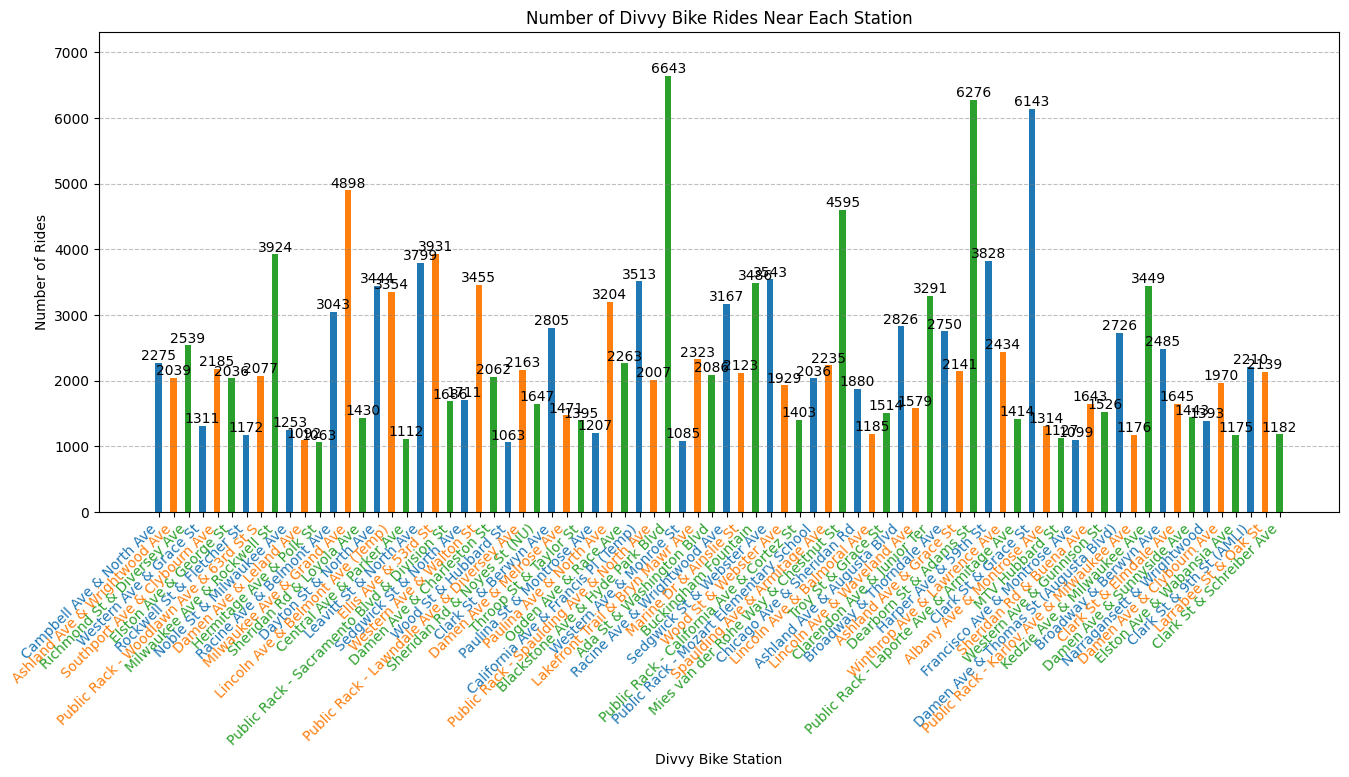

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the station data
stations_data = pd.read_csv('stations_only_in_binned.csv')
stations = stations_data['station_name'].tolist()

# Load the bike ride data
bike_ride_data = pd.read_csv('binned_nearest_divvy_location.csv')

# Count the number of rides near each station
rides_count = bike_ride_data['nearest_station_name'].value_counts().loc[stations]

# Adjust spacing parameters
bar_width = 0.6  # Decrease the bar width
spacing = 0.2  # Increase the spacing between bars

fig, ax = plt.subplots(figsize=(16, 10))

# Define the colors for the bars and names
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  
num_colors = len(colors)

# Calculate the total width for each station including spacing
total_width = bar_width * num_colors + spacing * (num_colors - 1)

# Calculate the starting position for each station
x = np.arange(len(stations)) * total_width

# Create the bar graph with colored bars
bars = ax.bar(x, rides_count, width=1, align='edge', color=colors * (len(stations) // num_colors + 1))

# Add spacing between the bars and labels
ax.bar_label(bars, fmt='%d')
ax.margins(y=0.1)

# Add spacing between the station names
ax.set_xticks(x + (num_colors - 1) * bar_width / 2)
ax.set_xticklabels(stations, rotation=45, ha='right')
plt.subplots_adjust(bottom=0.4)

# Set colors for the station names
xtick_labels = ax.get_xticklabels()
for i, label in enumerate(xtick_labels):
    label.set_color(colors[i % num_colors])

# Set colors for the grid lines
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.5)
ax.xaxis.grid(False)

# Set axis labels and title
ax.set_xlabel('Divvy Bike Station')
ax.set_ylabel('Number of Rides')
ax.set_title('Number of Divvy Bike Rides Near Each Station')

plt.show()







In [8]:
# Sort the rides_count series in descending order and retrieve the top 5 values
top_stations = rides_count.sort_values(ascending=False).head(5)

# Get the names and ride counts of the top 5 stations
top_station_names = top_stations.index.tolist()
top_station_rides = top_stations.values.tolist()

# Print the names and ride counts of the top 5 stations
for i in range(len(top_station_names)):
    print(f"Station: {top_station_names[i]}, Number of Rides: {top_station_rides[i]}")

#Create better advertising for these stations or determine where nearby you could add some more bikes as there are frequent riders here


Station: Blackstone Ave & Hyde Park Blvd, Number of Rides: 6643
Station: Dearborn St & Adams St, Number of Rides: 6276
Station: Clark St & Grace St, Number of Rides: 6143
Station: Milwaukee Ave & Grand Ave, Number of Rides: 4898
Station: Mies van der Rohe Way & Chestnut St, Number of Rides: 4595


In [16]:
import pandas as pd
from scipy.spatial import distance
import numpy as np
import time
from tqdm import tqdm

# Read the Divvy Bike stations data
df_stations = pd.read_csv('Divvy_Bicycle_Stations_-_All_-_Map.csv')

# Create a HashMap of station coordinates and names
station_map = dict(zip(zip(df_stations['Latitude'], df_stations['Longitude']), df_stations['Station Name']))

# Load the combined bike rides data in chunks
chunk_size = 100000
ride_chunks = pd.read_csv('combined_divvy_rides.csv', chunksize=chunk_size)

# Prepare a list to store filtered data
filtered_data = []

# Iterate over the ride chunks
for df_chunk in ride_chunks:
    # Filter rides that don't start or end at Divvy bike stations
    df_filtered = df_chunk[(df_chunk['start_station_id'].isna() | df_chunk['end_station_id'].isna())]

    # Filter out rows with missing or invalid coordinates
    df_filtered = df_filtered.dropna(subset=['start_lat', 'start_lng'])

    # Convert coordinates to float
    df_filtered['start_lat'] = df_filtered['start_lat'].astype(float)
    df_filtered['start_lng'] = df_filtered['start_lng'].astype(float)

    # Calculate distances using the HashMap
    ride_start_points = df_filtered[['start_lat', 'start_lng']].values
    nearest_station_coords = list(station_map.keys())
    distances = distance.cdist(ride_start_points, nearest_station_coords, metric='cityblock')
    nearest_station_indices = distances.argmin(axis=1)
    nearest_station_names = [station_map[nearest_station_coords[i]] for i in nearest_station_indices]

    # Add the filtered data to the list
    df_filtered['nearest_station_distance'] = distances.min(axis=1)
    df_filtered['nearest_station_name'] = nearest_station_names
    filtered_data.append(df_filtered)

# Concatenate all filtered data into a single DataFrame
df_filtered = pd.concat(filtered_data)

# Select the required columns
columns_to_keep = ['nearest_station_distance', 'nearest_station_name', 'start_lat', 'start_lng', 'end_lat', 'end_lng']
df_filtered = df_filtered[columns_to_keep]

# Save the filtered data to a new file
df_filtered.to_csv('binned_farthest_divvy_location.csv', index=False)

# Preparation Stage
start = time.time()

# Define the values to bin
values = df_filtered['nearest_station_distance'].values

# Set the number of bins
bins = 99999

# Calculate bin intervals
values_min = values.min()
values_max = values.max()
values_range = values_max - values_min
interval_range = values_range / bins

bin_intervals = {b: (values_min + b * interval_range, values_min + (b + 1) * interval_range) for b in range(bins)}

# Fill up bins with indices of values
bin_idx_dict = {}
for b, interval in tqdm(bin_intervals.items()):
    low = interval[0]
    high = interval[1]
    bin_idx_dict[b] = np.where((values >= low) & (values < high))[0].flatten()

end = time.time()
print(end - start)

# Implementation
start = time.time()

# Define the value to bin mapping function
val_to_bin_idx = lambda x: int((x - values_min) / interval_range)

# Define the value for which to find the nearest neighbors
val_match = values.max()  # Maximum distance between the bike and any of the stations

# Handle the case where the maximum bin index exceeds the valid range
if val_match == values_max:
    neighbor_bin_idx_center = bins - 1
else:
    neighbor_bin_idx_center = val_to_bin_idx(val_match)

neighbor_center_idx = bin_idx_dict[neighbor_bin_idx_center]
neighbor_center = values[neighbor_center_idx]


neighbor_left = None
neighbor_bin_idx_left = neighbor_bin_idx_center
while neighbor_left is None:
    neighbor_bin_idx_left -= 1
    try:
        neighbor_left_idx = bin_idx_dict[neighbor_bin_idx_left]
        if neighbor_left_idx.shape[0] > 0:
            neighbor_left = values[neighbor_left_idx]
    except KeyError:
        neighbor_left_idx = np.array([])
        neighbor_left = np.array([])

neighbor_right = None
neighbor_bin_idx_right = neighbor_bin_idx_center
while neighbor_right is None:
    neighbor_bin_idx_right += 1
    try:
        neighbor_right_idx = bin_idx_dict[neighbor_bin_idx_right]
        if neighbor_right_idx.shape[0] > 0:
            neighbor_right = values[neighbor_right_idx]
    except KeyError:
        neighbor_right_idx = np.array([])
        neighbor_right = np.array([])

neighbor_idx = np.concatenate([neighbor_left_idx, neighbor_center_idx, neighbor_right_idx]).astype(int)
neighbors = np.concatenate([neighbor_left, neighbor_center, neighbor_right])

dist1d = np.abs(neighbors - val_match)
max_dist = dist1d.max()
idx = np.where(dist1d == max_dist)[0]
print(val_match)
print(neighbor_idx[idx], values[neighbor_idx[idx]])

end = time.time()
print(end - start)





<ipython-input-16-448d2fccdcc1>:21: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-16-448d2fccdcc1>:21: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-16-448d2fccdcc1>:21: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-16-448d2fccdcc1>:21: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-16-448d2fccdcc1>:21: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_chunk in ride_chunks:
<ipython-input-16-448d2fccdcc1>:21: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set

272.05163502693176
0.038181000000001575
[967506] [0.029557]
0.01184391975402832


In [9]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Read the filtered data with farthest Divvy bike ride locations
df_filtered = pd.read_csv('binned_farthest_divvy_location.csv')

# Group the data by start station coordinates and count the number of occurrences
station_counts = df_filtered.groupby(['end_lat', 'end_lng', 'nearest_station_name']).size().reset_index(name='count')

# Sort the stations by count in descending order
station_counts = station_counts.sort_values('count', ascending=False)

# Take the top N stations with the highest count
top_n_stations = station_counts.head(200)

# Create a folium map centered around Chicago
map_divvy = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Add a heatmap layer based on the end station coordinates and count
heatmap_data = top_n_stations[['end_lat', 'end_lng', 'count']].values.tolist()
HeatMap(heatmap_data).add_to(map_divvy)

# Add markers for the top N stations
for idx, row in top_n_stations.iterrows():
    lat, lng = row['end_lat'], row['end_lng']
    count = row['count']
    station_name = row['nearest_station_name']
    folium.Marker(
        location=[lat, lng],
        popup=f"Station: {station_name}<br>Count: {count}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map_divvy)

# Get the maximum distance
max_distance = df_filtered['nearest_station_distance'].max()

# Add points for all the farthest Divvy bike ride locations
farthest_locations = df_filtered.loc[df_filtered['nearest_station_distance'] >= max_distance]
for idx, row in farthest_locations.iterrows():
    lat, lng = row['end_lat'], row['end_lng']
    color = 'red' if row['nearest_station_distance'] == max_distance else 'orange'
    folium.CircleMarker(
        location=[lat, lng],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
    ).add_to(map_divvy)
    print(f"Latitude: {lat}, Longitude: {lng}")

# Display the map
map_divvy





Latitude: 41.68, Longitude: -87.72
Latitude: 41.68, Longitude: -87.74
Latitude: 41.66, Longitude: -87.64
Latitude: 41.69, Longitude: -87.61
Latitude: 41.68, Longitude: -87.74
Latitude: 41.66, Longitude: -87.64
Latitude: 41.69, Longitude: -87.61
Latitude: 41.69, Longitude: -87.61
Latitude: 41.69, Longitude: -87.61
Latitude: 41.69, Longitude: -87.61
Latitude: 41.68493159519296, Longitude: -87.6452887058258
Latitude: 41.69, Longitude: -87.61
Latitude: 41.69, Longitude: -87.61
Latitude: 41.69, Longitude: -87.61
Latitude: 41.69, Longitude: -87.61
Latitude: 41.69, Longitude: -87.61
Latitude: 41.69, Longitude: -87.61
Latitude: 41.69, Longitude: -87.61
Latitude: 41.68, Longitude: -87.74
Latitude: 41.69, Longitude: -87.61
Latitude: 41.69, Longitude: -87.61


In [41]:
import pandas as pd

# Read the binned_farthest_divvy_location.csv file
df_farthest = pd.read_csv('binned_farthest_divvy_location.csv')

# Read the binned_nearest_divvy_location.csv file
df_nearest = pd.read_csv('binned_nearest_divvy_location.csv')

# Extract the unique station names from both dataframes
farthest_station_names = set(df_farthest['nearest_station_name'])
nearest_station_names = set(df_nearest['nearest_station_name'])

# Find the station names that are in farthest dataset but not in nearest dataset
station_names_not_in_nearest = farthest_station_names - nearest_station_names

# Create a dataframe with the station names
station_names_df = pd.DataFrame({'station_name': list(station_names_not_in_nearest)})

# Save the dataframe to a CSV file
station_names_df.to_csv('station_names_not_in_nearest.csv', index=False)



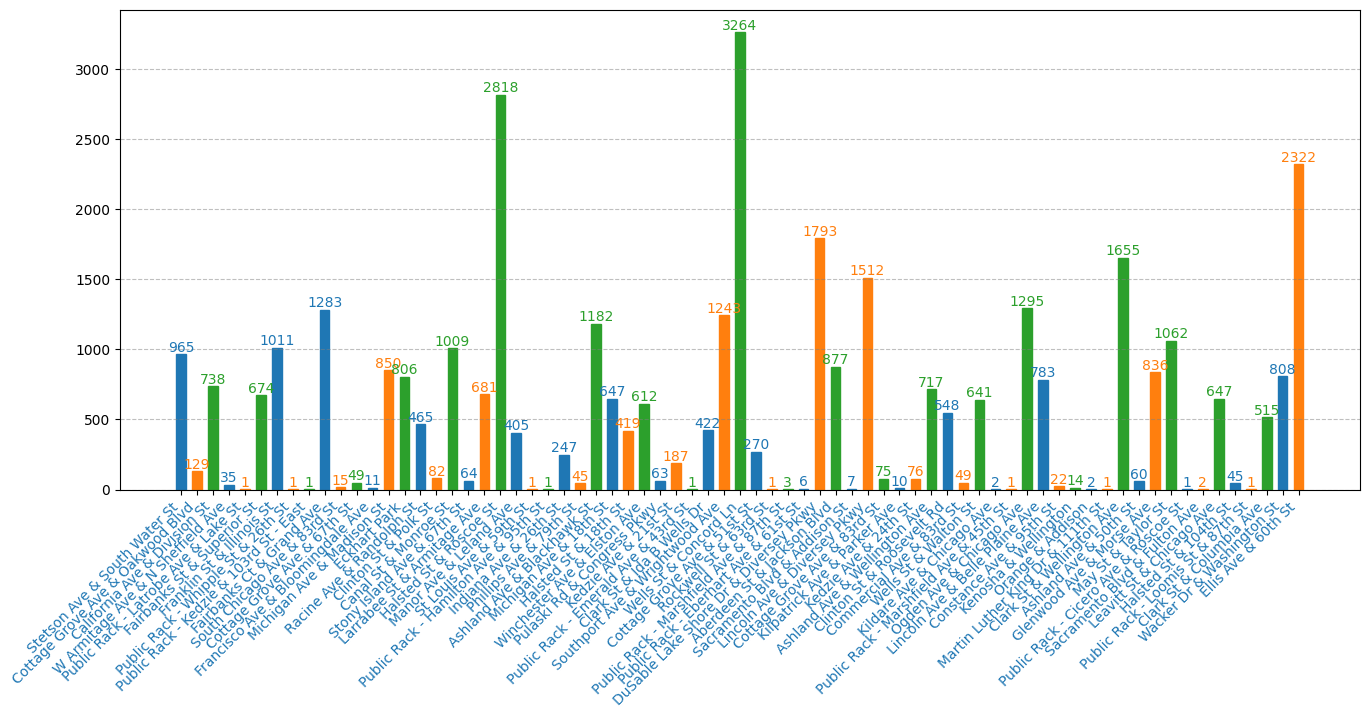

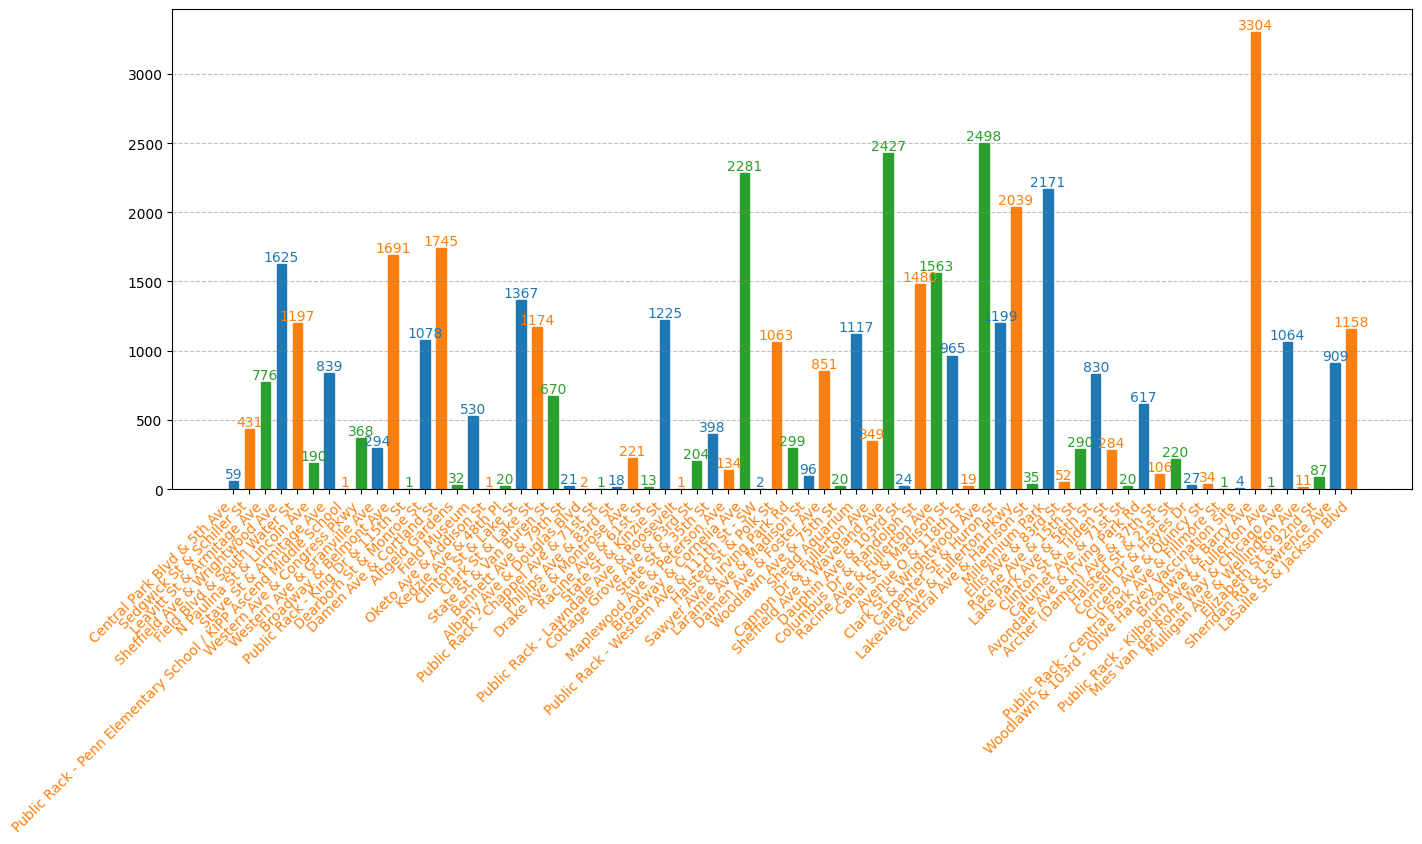

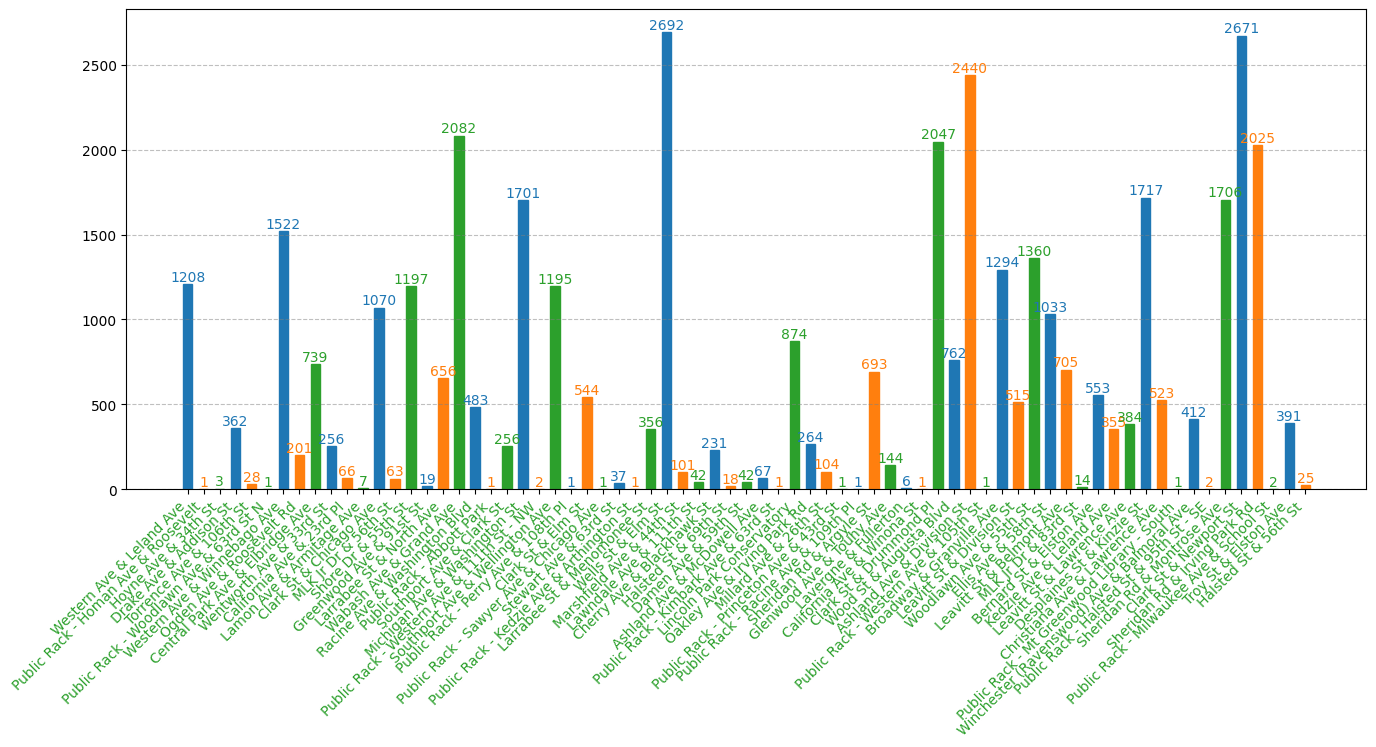

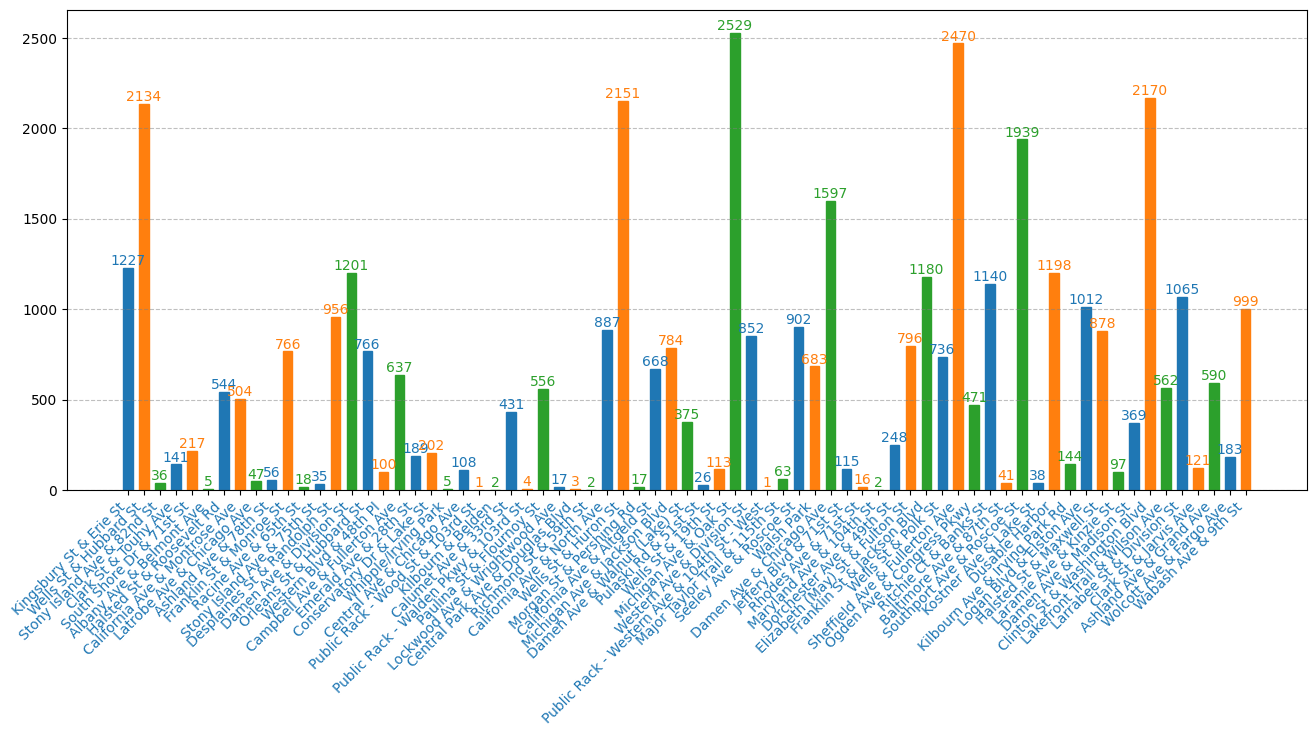

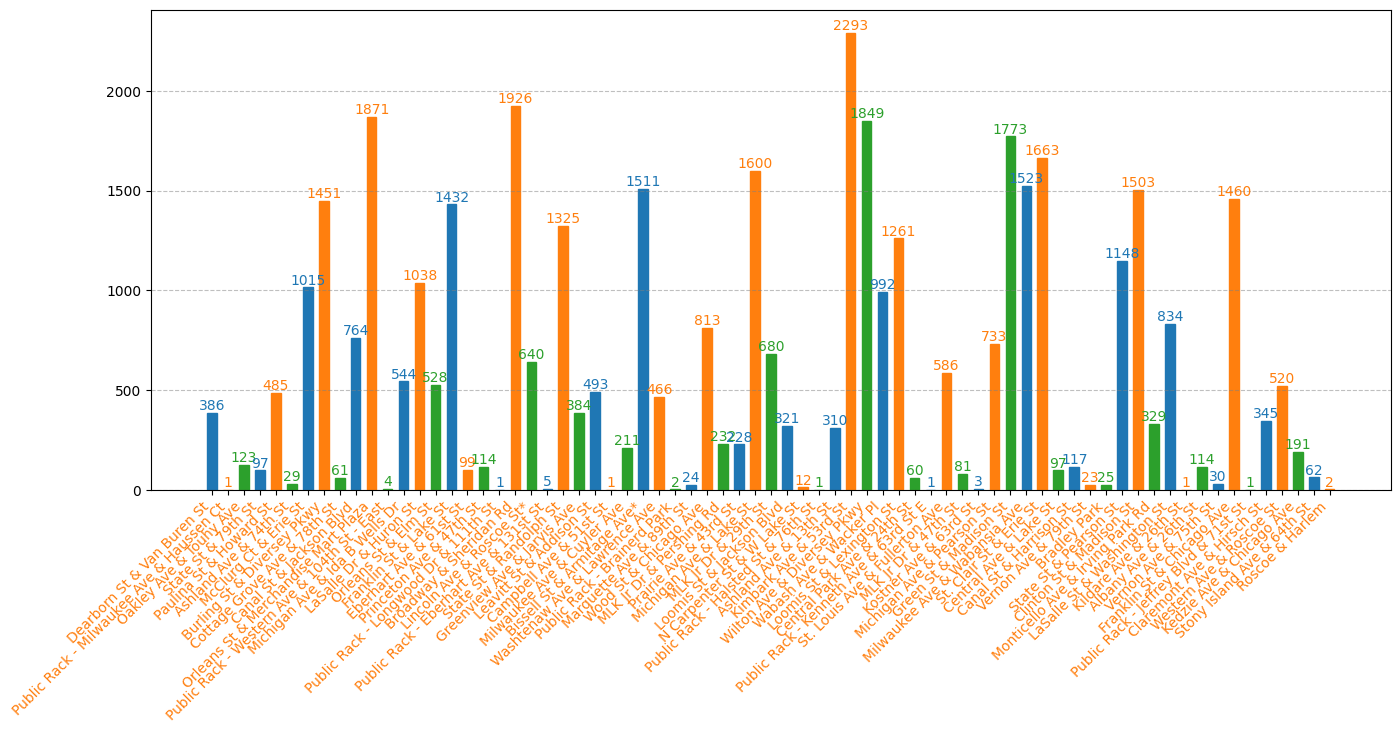

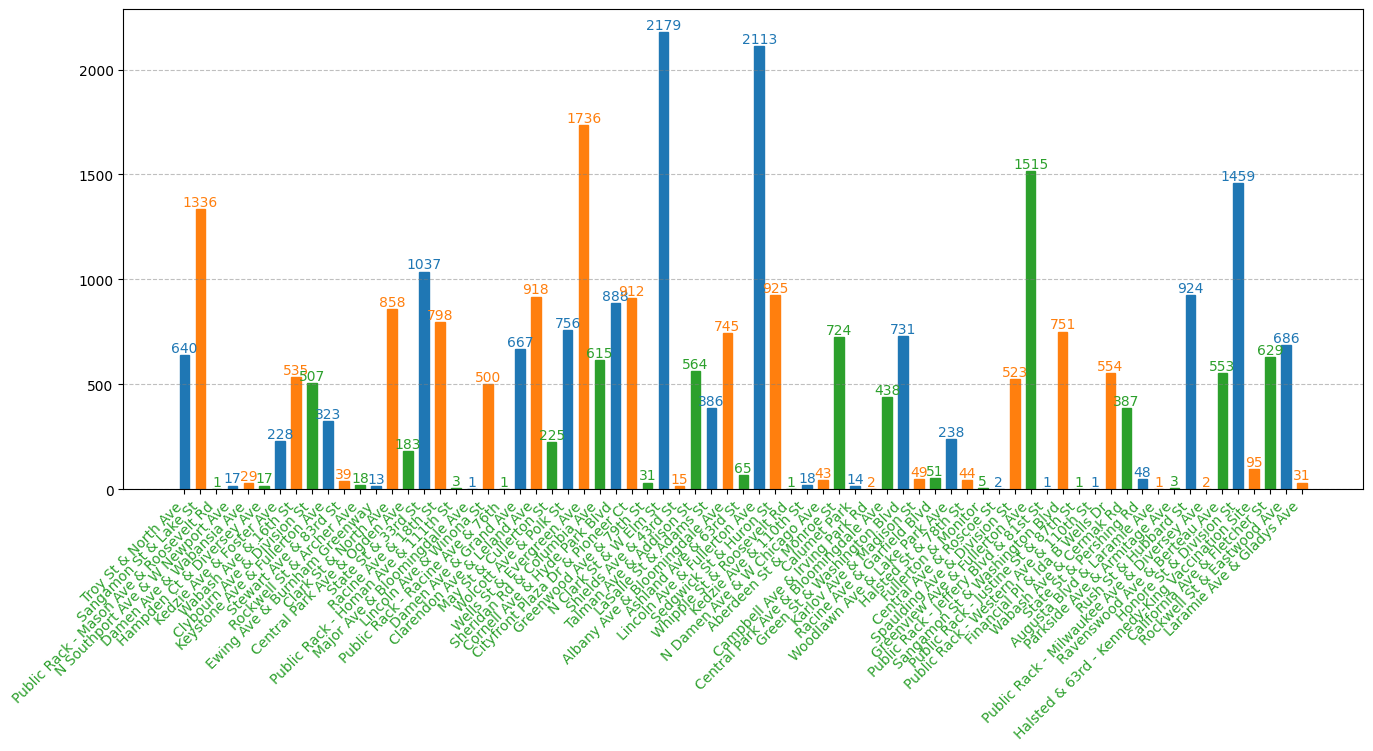

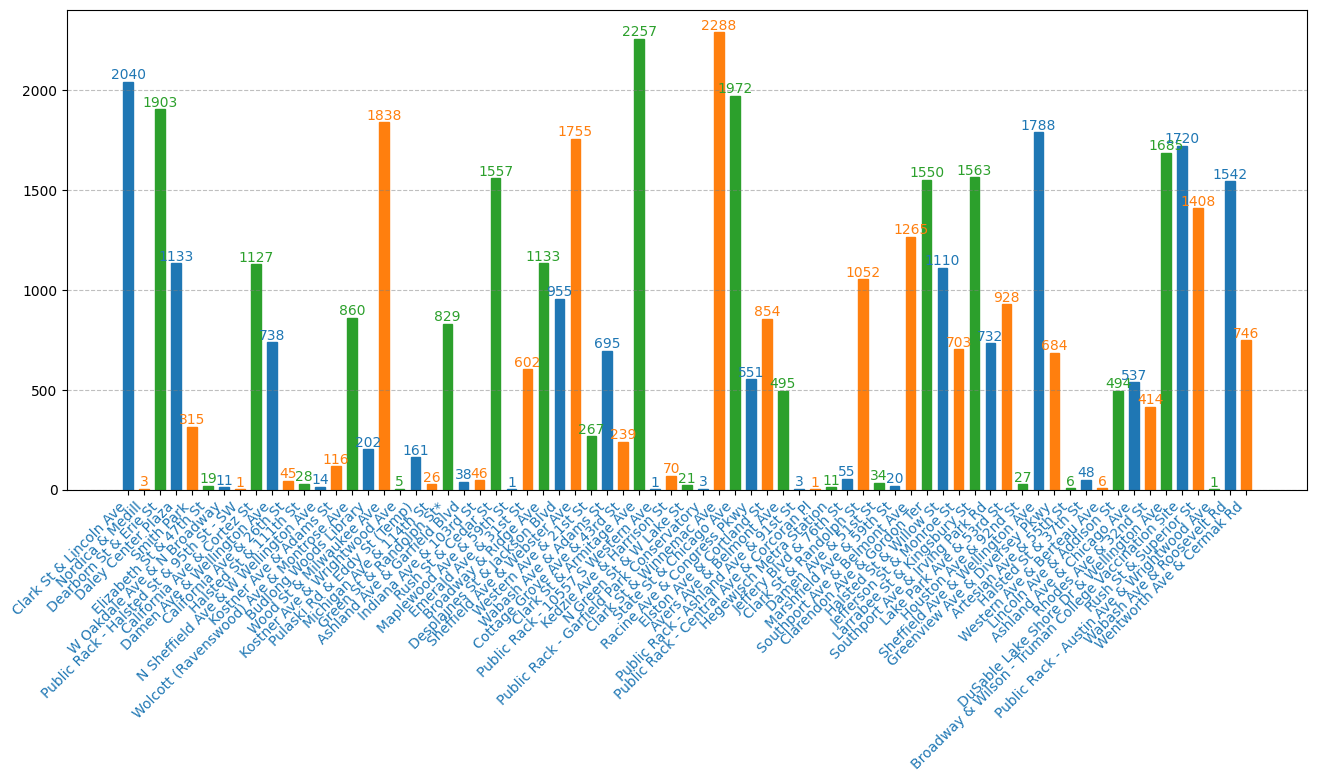

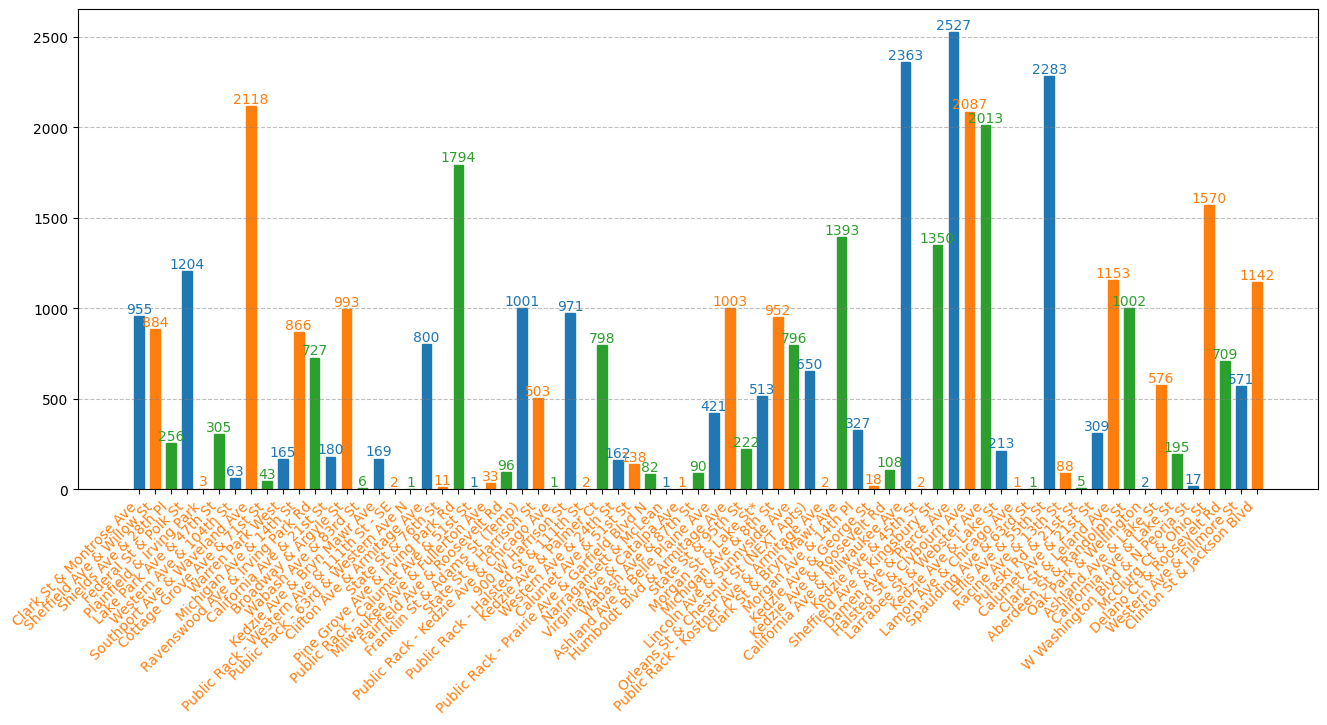

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the station_names_not_in_nearest.csv file
df = pd.read_csv('station_names_not_in_nearest.csv')

# Load the bike ride data
bike_ride_data = pd.read_csv('binned_farthest_divvy_location.csv')

# Count the number of rides for each station in station_names_not_in_nearest
rides_count = bike_ride_data['nearest_station_name'].value_counts()

# Initialize the list to store the counts for each subset
subset_counts = []

# Split the stations into 8 subsets
num_subsets = 8
subset_size = len(df) // num_subsets
subsets = [df[i * subset_size:(i + 1) * subset_size] for i in range(num_subsets)]

# Define the colors for the bars, numbers, and names
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Use the specified colors

# Create separate plots for each subset of stations
for i, subset in enumerate(subsets):
    fig, ax = plt.subplots(figsize=(16, 10))

    # Calculate the starting position for each station in the subset
    x = np.arange(len(subset))

    # Calculate the count for each station in the subset
    subset_station_counts = rides_count.loc[subset['station_name']].fillna(0)

    # Append the counts to the list of subset counts
    subset_counts.append(subset_station_counts)

    # Create the bar graph with alternating colored bars
    bars = ax.bar(x, subset_station_counts, width=bar_width, align='center', color=colors[i % len(colors)])

    # Set colors for the column names
    xtick_labels = ax.get_xticklabels()
    for j, label in enumerate(xtick_labels):
        label.set_color(colors[j % len(colors) + (i * len(colors)) % len(colors)])

    # Set colors for the bars
    for j, bar in enumerate(bars):
        bar.set_color(colors[j % len(colors) + (i * len(colors)) % len(colors)])

        # Add the ride count as text on top of each bar
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(bar.get_height()), ha='center',
                va='bottom', color=colors[j % len(colors) + (i * len(colors)) % len(colors)])

    # Add spacing between the station names
    ax.set_xticks(x)
    ax.set_xticklabels(subset['station_name'], rotation=45, ha='right', color=colors[i % len(colors)])

    plt.subplots_adjust(bottom=0.4)

    # Set colors for the grid lines
    ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.5)
    ax.xaxis.grid







In [11]:
import pandas as pd
import folium
from folium.plugins import HeatMap
from sklearn.cluster import KMeans

# Read the filtered data with farthest Divvy bike ride locations
df_filtered = pd.read_csv('binned_farthest_divvy_location.csv')

# Get the farthest locations with their coordinates
farthest_locations = df_filtered.loc[df_filtered['nearest_station_distance'] >= df_filtered['nearest_station_distance'].max()]
location_data = farthest_locations[['end_lat', 'end_lng']]

# Apply K-means clustering to find two central locations
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(location_data)
central_locations = kmeans.cluster_centers_

# Create a folium map centered around Chicago
map_divvy = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Add a heatmap layer based on the end station coordinates and count
heatmap_data = farthest_locations[['end_lat', 'end_lng']].values.tolist()
HeatMap(heatmap_data).add_to(map_divvy)

# Add markers for the central locations
for location in central_locations:
    lat, lng = location
    folium.Marker(
        location=[lat, lng],
        popup=f"Latitude: {lat}<br>Longitude: {lng}",
        icon=folium.Icon(color='green', icon='star')
    ).add_to(map_divvy)

# Display the map
map_divvy



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
